In [1]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from transformer_autoencoder import TransformerAutoEncoder
from torch.utils.data import DataLoader, Dataset

In [55]:
def classify_prompt(prompt, transformer_ae, threshold, device, scale_loss=False):
    transformer_ae.model.eval()
    with torch.no_grad():
        inputs = transformer_ae.tokenize_prompts([prompt])
        outputs = transformer_ae.model(**inputs, labels=inputs["input_ids"])
        loss = outputs.loss.item()  # average loss per token
        if scale_loss:
            # Multiply by the sequence length to get total loss
            loss = loss * inputs["input_ids"].shape[1]
    classification = 1 if loss < threshold else 0
    return loss, classification


In [12]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_name = "facebook/bart-base"
max_length = 128

X_test = pd.read_csv("data/test.csv")['prompt'].tolist()

transformer_ae = TransformerAutoEncoder(model_name=model_name, device=device, max_length=max_length)
transformer_ae.model.load_state_dict(torch.load("transformer_checkpoint.pth", map_location=device))

/tmp/ipykernel_2397957/1548152119.py:8: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  transformer_ae.model.load_state_dict(torch.load("transformer_checkpoint.pth", map_locat

<All keys matched successfully>

Average Reconstruction Loss on Test Set: 0.0014


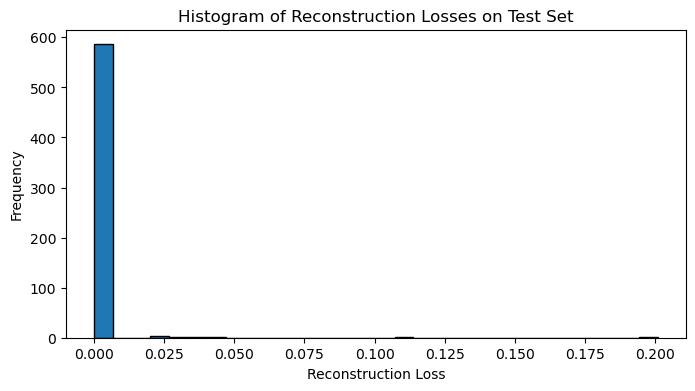

In [13]:
all_losses = []
transformer_ae.model.eval()
with torch.no_grad():
    for prompt in X_test:
        # Tokenize the prompt
        inputs = transformer_ae.tokenize_prompts([prompt])
        # Forward pass; the model calculates token-level crossentropy loss
        outputs = transformer_ae.model(**inputs, labels=inputs["input_ids"])
        loss = outputs.loss.item()  # get the scalar loss value
        all_losses.append(loss)

all_losses = np.array(all_losses)
print("Average Reconstruction Loss on Test Set: {:.4f}".format(np.mean(all_losses)))

# Plot the histogram of reconstruction losses
plt.figure(figsize=(8, 4))
plt.hist(all_losses, bins=30, edgecolor='black')
plt.title("Histogram of Reconstruction Losses on Test Set")
plt.xlabel("Reconstruction Loss")
plt.ylabel("Frequency")
plt.show()

In [28]:
mean_error = np.mean(all_losses)
std_error = np.std(all_losses)
threshold = mean_error + std_error
print(f"Mean error: {mean_error:.4f}, Std error: {std_error:.4f}")
print(f"Threshold set at: {threshold:.4f}")

threshold = 0.00001

Mean error: 0.0014, Std error: 0.0129
Threshold set at: 0.0143


In [61]:
# Suppose 'reconstruction_errors' is your array of losses:
threshold_percentile = 95  # or 99
threshold = np.percentile(reconstruction_errors, threshold_percentile)
print("Threshold set at the {}th percentile: {:.4f}".format(threshold_percentile, threshold))


Threshold set at the 95th percentile: 0.0007


In [15]:
from datasets import load_dataset

ds = load_dataset("JailbreakBench/JBB-Behaviors", "behaviors")

In [18]:
# Load test data (assumes a CSV with a 'prompt' column)
new_prompts = ds['harmful']['Goal']

errors = []
classifications = []

for prompt in X_test:
    loss, classification = classify_prompt(prompt, transformer_ae, threshold, device)
    errors.append(loss)
    classifications.append(classification)

reconstruction_errors = np.array(errors)
print(f"Average Reconstruction Loss on Test Set: {np.mean(reconstruction_errors):.4f}")

Average Reconstruction Loss on Test Set: 0.0014


In [63]:
loss, classification = classify_prompt("how can i write a letter?", transformer_ae, threshold, device, scale_loss=True)

classification, loss

(1, 0.00012266488829482114)